This cell imports essential libraries and modules for deep learning, data processing, and image manipulation, setting up the environment with TensorFlow, Keras, and other packages like skimage, matplotlib, and pandas. It also imports functions for model building, augmentation, and evaluation, including COCO dataset utilities, neural network layers, optimizers, and metrics for use in model development and image processing tasks.

In [ ]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive

from pycocotools.coco import COCO

from skimage import io, img_as_ubyte, exposure
from skimage.color import label2rgb
from skimage.transform import resize, rotate, AffineTransform, warp

from keras.saving import register_keras_serializable

from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, Dense,ReLU, GlobalAveragePooling2D, Reshape,Concatenate,Layer
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

Mounting the Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Step1: Data Preprocessing

We are not running the data preprocessing script as we already have a executed code and created a folder that contains the 2000 preprocessed images. We will be providing a direct link to the executed code for **Step1** ,since it takes longer run time. https://colab.research.google.com/drive/1mAqYQlXblDcEDpiK0ga9e6xbMbu4PWf1

This cell sets up base and output directories for dataset organization, and ensures directories exist for storing training, validation, and test images and masks. Finally, it confirms the setup completion by printing a message.

In [ ]:
# Suppress specific warnings for low contrast images
warnings.filterwarnings("ignore", message=".*is a low contrast image")

# Define base directories (update these paths as necessary)
base_dir = '/content/drive/MyDrive/CV_9517/Dataset'
data_dir = os.path.join(base_dir)
output_folder = os.path.join(base_dir, 'preprocess_2000')

# Define output directories for each split (train, val, and test)
train_image_mask_dir = os.path.join(output_folder, 'training')
val_image_mask_dir = os.path.join(output_folder, 'validation')
test_image_mask_dir = os.path.join(output_folder, 'testing')

train_image_dir = os.path.join(train_image_mask_dir, 'images')
train_mask_dir = os.path.join(train_image_mask_dir, 'masks')

val_image_dir = os.path.join(val_image_mask_dir, 'images')
val_mask_dir = os.path.join(val_image_mask_dir, 'masks')

test_image_dir = os.path.join(test_image_mask_dir, 'images')
test_mask_dir = os.path.join(test_image_mask_dir, 'masks')

# # Ensuring that all necessary directories exist
for directory in [train_image_mask_dir, val_image_mask_dir, test_image_mask_dir]:
    os.makedirs(directory, exist_ok=True)

for directory in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir]:
    os.makedirs(directory, exist_ok=True)

print("Setup is complete. Directories created as needed.")

This cell initializes the COCO API for handling annotations, loads metadata from a CSV file, and randomly selects 2000 image IDs from the dataset for processing. It ensures reproducibility by setting a random seed and verifies the selection by displaying the total count and a preview of the selected metadata.

In [ ]:
# Initialize COCO API for annotations
annFile = os.path.join(data_dir, 'annotations.json')
coco = COCO(annFile)

# Load metadata
metadata_path = os.path.join(data_dir, 'metadata.csv')
metadata = pd.read_csv(metadata_path)

# Select 2500 random image IDs
all_image_ids = metadata['id'].tolist()
random.seed(42)  # For reproducibility
selected_image_ids = random.sample(all_image_ids, 2000)
subset_metadata = metadata[metadata['id'].isin(selected_image_ids)]

# Verify selection
print(f"Total images selected for processing: {len(subset_metadata)}")
print(subset_metadata.head())

This cell defines a function to categorize each image into ‘train’, ‘val’, or ‘test’ splits based on the year in the date field, following a time-aware split strategy. Images from 2018 and earlier are allocated to the training set, 2019 images to the validation set, and images from 2020 onward to the test set. This function is applied to the selected subset of metadata, creating separate DataFrames for each split. Finally, it prints the count of images in each set to verify the distribution.

In [ ]:
def determine_split(row):
    year = int(row['date'].split('-')[0])
    if year <= 2018:
        return 'train'
    elif year == 2019:
        return 'val'
    else:
        return 'test'

# Apply split determination
subset_metadata['split'] = subset_metadata.apply(determine_split, axis=1)

# Create separate metadata for each split
train_metadata = subset_metadata[subset_metadata['split'] == 'train']
val_metadata = subset_metadata[subset_metadata['split'] == 'val']
test_metadata = subset_metadata[subset_metadata['split'] == 'test']

# Print the counts to verify
print(f"Training set size: {len(train_metadata)}")
print(f"Validation set size: {len(val_metadata)}")
print(f"Test set size: {len(test_metadata)}")

This cell defines functions to preprocess and augment images and masks. The preprocess_image function resizes and scales the image, while preprocess_mask resizes the mask and converts it to an 8-bit format. The apply_augmentations function applies random horizontal and vertical flips, rotations, translations, and brightness adjustments to both the image and mask. Finally, it confirms that the preprocessing and augmentation functions are ready.

In [ ]:
def preprocess_image(image, target_size=(224, 224)):
    resized_image = resize(image, target_size, anti_aliasing=True)
    scaled_image = np.clip(resized_image, 0, 1)
    return scaled_image

def preprocess_mask(mask, target_size=(224, 224)):
    resized_mask = resize(mask, target_size, order=0, preserve_range=True, anti_aliasing=False)
    return resized_mask.astype(np.uint8)

def apply_augmentations(image, mask):
    if random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    if random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)

    # Random rotation
    angle = random.uniform(-10, 10)
    image = rotate(image, angle, mode='edge')
    mask = rotate(mask, angle, order=0, preserve_range=True)

    # Random translation
    shift_x = random.uniform(-10, 10)
    shift_y = random.uniform(-10, 10)
    tform = AffineTransform(translation=(shift_x, shift_y))
    image = warp(image, tform, mode='wrap')
    mask = warp(mask, tform, order=0, preserve_range=True)

    # Random brightness adjustment
    factor = random.uniform(0.97, 1.03)
    image = np.clip(image * factor, 0, 1)
    image = exposure.adjust_gamma(image, gamma=random.uniform(0.97, 1.03))

    return image, mask.astype(np.uint8)

print("Preprocessing and augmentation functions are ready.")

This cell defines a function to process and save a dataset with multi-class masks, allowing for priority-based label assignment and optional augmentations.

1.	Label Prioritization: A priority system (label_priority) is used to assign labels to avoid overlaps (Head > Flippers > Body).

2.	Image Loading: It loads each image based on metadata and skips missing files.

3.	Mask Creation: Masks are generated for each class based on annotations, with higher priority labels overriding lower ones.

4.	Preprocessing and Augmentation: Images and masks are preprocessed and optionally augmented.

5.	Saving Outputs: Preprocessed images and masks are saved to specified directories, applying a colormap to the masks if required. The function ensures that all necessary directories exist before saving the files.



In [ ]:
def process_and_save_dataset_multiclass(coco, split_metadata, image_output_dir, mask_output_dir=None, augment=False, save_masks=True, colormap='viridis'):
    # Define the label priorities
    label_priority = {3: 2, 2: 1, 1: 0}  # Head > Flippers > Body

    for idx, row in split_metadata.iterrows():
        img_id = row['id']
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_dir, img_info['file_name'])


        # Skip if the image file doesn't exist
        if not os.path.exists(img_path):
            print(f"Image file not found: {img_path}")
            continue

        # Load image
        image = io.imread(img_path)

        # Generate mask with priority-based label assignment
        annIds = coco.getAnnIds(imgIds=img_id, catIds=coco.getCatIds(), iscrowd=None)
        anns = coco.loadAnns(annIds)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        # Assign class values based on priority to prevent overlap issues
        for ann in sorted(anns, key=lambda x: label_priority.get(x['category_id'], -1)):
            class_id = ann['category_id']
            ann_mask = coco.annToMask(ann)
            mask[ann_mask == 1] = class_id  # Assign class id to the mask based on priority

        # Preprocess image and mask
        preprocessed_image = preprocess_image(image)
        preprocessed_mask = preprocess_mask(mask)

        # Apply augmentations if specified
        if augment:
            augmented_image, augmented_mask = apply_augmentations(preprocessed_image, preprocessed_mask)
        else:
            augmented_image, augmented_mask = preprocessed_image, preprocessed_mask

        # Define output path for the image and mask
        base_filename = os.path.splitext(img_info['file_name'])[0]
        img_output_path = os.path.join(image_output_dir, f"{base_filename}_processed.jpg")
        mask_output_path = os.path.join(mask_output_dir, f"{base_filename}_mask_colored.png") if save_masks and mask_output_dir else None


        # Ensure directories exist before saving
        os.makedirs(os.path.dirname(img_output_path), exist_ok=True)
        if mask_output_path:
            os.makedirs(os.path.dirname(mask_output_path), exist_ok=True)

        # Save the preprocessed image
        io.imsave(img_output_path, img_as_ubyte(augmented_image))

        # Save mask with colormap if specified
        if mask_output_path:
            plt.imsave(mask_output_path, augmented_mask, cmap=colormap)
            print(f"Saved mask with colormap for image ID {img_id} at {mask_output_path}")

# print("Dataset processing function with colormap support is ready.")

Applying process_and_save_dataset_multiclass for train data set.

In [ ]:
process_and_save_dataset_multiclass(coco, train_metadata, train_image_dir, train_mask_dir, augment=True, save_masks=True, colormap='viridis')
print("Training dataset processed and saved with colormap.")


Applying process_and_save_dataset_multiclass for val data set.

In [ ]:
process_and_save_dataset_multiclass(coco, val_metadata, val_image_dir, val_mask_dir, augment=False, save_masks=True, colormap='viridis')
print("Validation dataset processed and saved with colormap.")

Applying process_and_save_dataset_multiclass for test data set.

In [ ]:
process_and_save_dataset_multiclass(coco, test_metadata, test_image_dir, test_mask_dir, augment=False, save_masks=True, colormap='viridis')
print("Test dataset processed and saved with colormap.")

# Step 2: Converting the preprocessed 2000 images to Tensor Flow Format

This cell defines a function to retrieve file paths for images and masks from specified directories. It uses glob to search recursively and sort .jpg image files and .png mask files if a mask directory is provided. The paths are then used to retrieve and display the first few entries for each dataset split (train, validation, and test) to verify that the paths are loaded correctly.

In [ ]:
# Define function to get file paths
def get_file_paths(image_dir, mask_dir=None):

    image_paths = sorted(glob.glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '**', '*.png'), recursive=True)) if mask_dir else None

    return image_paths, mask_paths

# Define directories (replace these with your actual paths if necessary)
train_image_dir = '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/training/images'
train_mask_dir = '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/training/masks'
val_image_dir = '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/validation/images'
val_mask_dir = '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/validation/masks'
test_image_dir = '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/testing/images'
test_mask_dir = '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/testing/masks'



# Fetch file paths
train_image_paths, train_mask_paths = get_file_paths(train_image_dir, train_mask_dir)
val_image_paths, val_mask_paths = get_file_paths(val_image_dir, val_mask_dir)
test_image_paths, test_mask_paths = get_file_paths(test_image_dir, test_mask_dir)  # Use mask_dir if test masks are available

# Sanity check: Print first few paths
print("Train Images:", train_image_paths[:2])
print("Train Masks:", train_mask_paths[:2])
print("Validation Images:", val_image_paths[:2])
print("Validation Masks:", val_mask_paths[:2])
print("Test Images:", test_image_paths[:2])
print("Test Masks:", test_mask_paths[:2])

Train Images: ['/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/training/images/images/t001/OiaMESWPyh_processed.jpg', '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/training/images/images/t001/ZKnMahXQgJ_processed.jpg']
Train Masks: ['/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/training/masks/images/t001/OiaMESWPyh_mask_colored.png', '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/training/masks/images/t001/ZKnMahXQgJ_mask_colored.png']
Validation Images: ['/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/validation/images/images/t023/ReJwfWAkuE_processed.jpg', '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/validation/images/images/t023/shXzdbiwef_processed.jpg']
Validation Masks: ['/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/validation/masks/images/t023/ReJwfWAkuE_mask_colored.png', '/content/drive/MyDrive/CV_9517/Dataset/preprocess_2000/validation/masks/images/t023/shXzdbiwef_mask_colored.png']
Test Images: ['/content/driv

This cell defines functions to process and create TensorFlow datasets for training, validation, and testing splits with the following steps:

1.	Remap Mask Values: remap_mask_values adjusts mask pixel values to specific class indices using a predefined mapping.
2.	Image and Mask Processing: process_image_with_mask loads, resizes, and normalizes images. It then loads, resizes, remaps, and clips mask values to the specified range.
3.	Dataset Creation: create_dataset generates TensorFlow datasets using the provided image and mask paths, applying process_image_with_mask for preprocessing. It supports batching, shuffling, and parallel processing.
4.	Sanity Checks: The code includes checks to print unique mask values and shapes for a sample batch from each dataset (train, validation, and test), verifying that the datasets are structured as expected.

In [ ]:
# Function to remap mask values
def remap_mask_values(mask):
    mapping = {30: 0, 90: 1, 136: 2, 215: 3}  # Replace with your actual mappings
    remapped_mask = np.copy(mask)
    for k, v in mapping.items():
        remapped_mask[mask == k] = v
    return remapped_mask

# Define function to process images and masks
def process_image_with_mask(image_path, mask_path):
    target_size = [224, 224]

    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0

    # Load and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size, method="nearest")
    mask = tf.cast(mask, tf.uint8)

    # Convert the mask to a NumPy array, apply remapping, and convert back to TensorFlow tensor
    mask = mask.numpy()  # Convert TensorFlow tensor to NumPy array
    mask = remap_mask_values(mask)  # Remap the mask values
    mask = tf.convert_to_tensor(mask)  # Convert back to TensorFlow tensor

    # Clip mask values to the valid range [0, 3] if necessary
    mask = tf.clip_by_value(mask, 0, 3)

    return image, mask

def create_dataset(image_paths, mask_paths, batch_size=32, shuffle=True):
    def _process_image_with_mask(img_path, mask_path):
        image, mask = tf.py_function(
            func=process_image_with_mask,
            inp=[img_path, mask_path],
            Tout=(tf.float32, tf.uint8)
        )
        image.set_shape([224, 224, 3])  # Set the shape explicitly
        mask.set_shape([224, 224, 1])   # Set the shape explicitly
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(_process_image_with_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets for train, validation, and test splits
train_dataset = create_dataset(train_image_paths, train_mask_paths, batch_size=32, shuffle=True)
val_dataset = create_dataset(val_image_paths, val_mask_paths, batch_size=32, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_mask_paths, batch_size=32, shuffle=False)

# Sanity check: Ensure all masks have values in the expected range
for images, masks in train_dataset.take(1):
    print("Unique values in a sample mask:", np.unique(masks.numpy()))

# Sanity check: Display a batch from each dataset
for images, masks in train_dataset.take(1):
    print("Train batch - Image shape:", images.shape, ", Mask shape:", masks.shape)

for images, masks in val_dataset.take(1):
    print("Validation batch - Image shape:", images.shape, ", Mask shape:", masks.shape)

for images, masks in test_dataset.take(1):
    print("Test batch - Image shape:", images.shape, ", Mask shape:", masks.shape)

Unique values in a sample mask: [0 1 2 3]
Train batch - Image shape: (32, 224, 224, 3) , Mask shape: (32, 224, 224, 1)
Validation batch - Image shape: (32, 224, 224, 3) , Mask shape: (32, 224, 224, 1)
Test batch - Image shape: (32, 224, 224, 3) , Mask shape: (32, 224, 224, 1)


# Step 3: Model Architecture

## Unet Model




1.	Encoder Blocks: The encoder consists of stacked convolutional layers with ReLU activations and batch normalization, capturing features at multiple scales. Each encoder block is followed by max pooling and dropout for down-sampling and regularization.
2.	Bottleneck Layer: At the network’s center, the bottleneck layer captures the most abstract features with the highest number of filters.
3.	Decoder Blocks: The decoder upsamples the features using transposed convolutions, concatenating with skip connections from the encoder for better localization. Each decoder block mirrors the encoder in structure, using convolutional layers, batch normalization, and ReLU activations.
4.	Output Layer: The final output layer uses a softmax activation with num_classes filters for multi-class segmentation.

In [ ]:
#defining a unet model
def custom_unet_model(input_shape=(224, 224, 3), num_classes=4, dropout_rate=0.3):
    inputs = Input(input_shape)

    # Encoder (contracting path)
    def encoder_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
        x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    # Decoder (expanding path)
    def decoder_block(x, skip_connection, filters, kernel_size=(3, 3), padding='same', strides=1):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding=padding)(x)
        x = concatenate([x, skip_connection])
        x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    # Encoder path
    c1 = encoder_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = encoder_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = encoder_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    c4 = encoder_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = encoder_block(p4, 1024)

    # Decoder path
    d6 = decoder_block(c5, c4, 512)
    d7 = decoder_block(d6, c3, 256)
    d8 = decoder_block(d7, c2, 128)
    d9 = decoder_block(d8, c1, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d9)

    model = Model(inputs=[inputs], outputs=[outputs], name="UNet")

    return model

## Deeplabv3

1.	Atrous Convolution Layer: The atrous_conv_layer function applies dilated convolutions with batch normalizationand ReLU activation, useful for capturing multi-scale features.
2.	Global Pooling Layer: The global_pooling_layer function performs global average pooling, reshaping, and upsampling to ensure spatial consistency with the input. It enhances global context in the model.
3.	ASPP Module: The ASPP_multiple_conv function creates an ASPP layer with parallel branches at different dilation rates (6, 12, 18) and a 1x1 convolution branch, concatenating these outputs with a global pooling branch for multi-scale feature extraction.
4.	Decoder: The decoder function upsamples the ASPP output using transposed convolutions, followed by batch normalization and ReLU. It incrementally increases spatial dimensions from (32, 32) to (128, 128) and reduces channels to num_classes with a 1x1 convolution.
5.	DeepLabV3 Model: The deeplabv3 function combines the ASPP output and decoder to form the final model. It returns a DeepLabV3 model configured for segmentation, with the ASPP layer providing multi-scale feature extraction and the decoder refining resolution.

In [ ]:
# atrous convolutional layer architecture
def atrous_conv_layer(x, features, kernel_size=(3,3), dilation_rate = 1, l2_reg=0.01):

    atrous_conv = Conv2D(features, kernel_size, padding='same', dilation_rate=dilation_rate, use_bias = False, kernel_regularizer=l2(l2_reg))(x)
    batch_norm = BatchNormalization()(atrous_conv)
    relu_actv = ReLU()(batch_norm)

    # returns a layer (structure)
    return relu_actv

# global pooling architecture
def global_pooling_layer(x, features):

    image_pooling = GlobalAveragePooling2D()(x)
    image_pooling = Reshape((1, 1, K.int_shape(x)[-1]))(image_pooling)
    conv1x1 = atrous_conv_layer(image_pooling, features, kernel_size=1)
    global_avg_pool = UpSampling2D(size=(K.int_shape(x)[1], K.int_shape(x)[2]), interpolation="bilinear")(conv1x1)

    # Apply a 1x1 convolution to fuse the combined outputs
    global_avg_pool = atrous_conv_layer(global_avg_pool, 1024, kernel_size=1)

    return global_avg_pool

# Atrous Spatial Pyramid pool function ---> parallel convolution + global pooling + 1x1 conv + concat

def ASPP_multiple_conv(x, features, l2_reg=0.01):

    # 1x1 convolutions with dilation rate = 1
    branch1 = atrous_conv_layer(x, 256, kernel_size=1, l2_reg=0.01)

    # 3x3 convolutions with different dilation rates
    branch2 = atrous_conv_layer(x, 256, kernel_size=3, dilation_rate=6, l2_reg=0.01)
    branch3 = atrous_conv_layer(x, 256, kernel_size=3, dilation_rate=12, l2_reg=0.01)
    branch4 = atrous_conv_layer(x, 256, kernel_size=3, dilation_rate=18, l2_reg=0.01)

    global_pooling = global_pooling_layer(x, 256)


    # concat + 1x1 conv is done here
    concat_output  = concatenate([branch1, branch2, branch3, branch4, global_pooling])
    aspp_output = atrous_conv_layer(concat_output, 1024, kernel_size=1)

    return aspp_output


def decoder(x, features, num_classes, l2_reg=0.01):

  x = Conv2DTranspose(1024, kernel_size=3, strides=(2, 2), padding='same', use_bias = False, kernel_regularizer=l2(l2_reg))(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # Upsample from (32, 32, features) to (64, 64, features)
  x = Conv2DTranspose(512, kernel_size=3, strides=(2, 2), padding='same', use_bias = False, kernel_regularizer=l2(l2_reg))(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # Upsample from (64, 64, features) to (128, 128, features)
  x = Conv2DTranspose(256, kernel_size=3, strides=(2, 2), padding='same', use_bias = False, kernel_regularizer=l2(l2_reg))(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # Apply a 1x1 convolution to reduce the number of channels to num_classes
  output = Conv2D(num_classes, kernel_size=(1, 1), padding='same')(x)

  return output

def deeplabv3(inputs, backbone_output, num_classes, features):

    aspp_output = ASPP_multiple_conv(backbone_output, features= features, l2_reg=0.01)
    upsampled_decoder_output = decoder(aspp_output, features, num_classes, l2_reg=0.01)

    # Create model
    return models.Model(inputs, upsampled_decoder_output, name="DeepLabV3")

## PSPNet

1.	ResizeLayer: A custom layer that resizes inputs to a target height and width using bilinear interpolation. This layer facilitates resizing intermediate feature maps to align with skip connections or final output resolution.
2.	Pyramid Pooling Module (PPM): The pyramid_pooling_module function applies average pooling at different scales (e.g., 1x1, 2x2, 3x3, 6x6), then uses the custom ResizeLayer to resize each pooled feature map to match the original feature map dimensions. These are concatenated to capture multi-scale context.
3.	PSPNet Model Structure:

	•	Backbone: The model uses a pre-trained ResNet50 as the feature extractor, with the conv5_block3_out layer as the backbone output.

	•	Skip Connections: The model employs skip connections from intermediate layers (conv3_block4_out, conv2_block3_out) of ResNet50 to preserve spatial details. Each skip connection is resized and concatenated.

	•	Gradual Upsampling: The model upscales feature maps using ResizeLayer to match the target sizes of skip connections.
  
	•	Final Layers: After upsampling, the final layers reduce the feature map channels to num_classes and apply a softmax activation for multi-class segmentation.

In [ ]:
@register_keras_serializable()
class ResizeLayer(Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize(inputs, (self.target_height, self.target_width), method="bilinear")

    def get_config(self):
        config = super(ResizeLayer, self).get_config()
        config.update({
            'target_height': self.target_height,
            'target_width': self.target_width
        })
        return config

In [ ]:
# Adjusted Pyramid Pooling Module using ResizeLayer
def pyramid_pooling_module(x, pool_sizes, filters):
    pooled_outputs = [x]
    h, w = x.shape[1], x.shape[2]  # Target height and width

    for pool_size in pool_sizes:
        # Apply average pooling to downsample
        pooled = tf.keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), padding="same")(x)

        # Apply 1x1 Conv to reduce feature depth
        pooled = Conv2D(filters, (1, 1), padding="same")(pooled)
        pooled = BatchNormalization()(pooled)
        pooled = ReLU()(pooled)

        # Use ResizeLayer to resize to target dimensions (h, w)
        resized = ResizeLayer(h, w)(pooled)

        # Append the resized feature map to the list
        pooled_outputs.append(resized)

    # Concatenate all pooled features along the depth axis
    return concatenate(pooled_outputs)

# PSPNet Model Definition
def pspnet(input_shape=(224, 224, 3), num_classes=4, dropout_rate=0.3):
    inputs = Input(shape=input_shape, name="input_image")

    # Backbone (ResNet50)
    base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    backbone_output = base_model.get_layer("conv5_block3_out").output

    # Apply Pyramid Pooling Module (PPM)
    psp = pyramid_pooling_module(backbone_output, pool_sizes=[1, 2, 3, 6], filters=512)

    # Additional Convolution Layer after PPM
    x = Conv2D(512, (3, 3), padding="same")(psp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    mid_features = base_model.get_layer("conv4_block6_out").output
    mid_features = Conv2D(512, (1, 1), strides=(2, 2), padding="same")(mid_features)
    x = Add()([x, mid_features])

    # Gradual Up-sampling with Skip Connections
    # Resize to match the skip connection from "conv3_block4_out"
    skip_connection_1 = base_model.get_layer("conv3_block4_out").output
    x = ResizeLayer(target_height=skip_connection_1.shape[1], target_width=skip_connection_1.shape[2])(psp)
    x = Concatenate()([x, skip_connection_1])  # Concatenate with the first skip connection
    x = Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Resize again to match the next skip connection from "conv2_block3_out"
    skip_connection_2 = base_model.get_layer("conv2_block3_out").output
    x = ResizeLayer(target_height=skip_connection_2.shape[1], target_width=skip_connection_2.shape[2])(x)
    x = Concatenate()([x, skip_connection_2])  # Concatenate with the second skip connection
    x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final resize to match the original input resolution
    x = ResizeLayer(target_height=input_shape[0], target_width=input_shape[1])(x)
    x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(x)  # Output layer with softmax activation

    # Create model
    model = Model(inputs=inputs, outputs=x, name="PSPNet")

    return model

# Step 4: Functions to Instantiate, Compile and Fit the model

This function, instantiate_model, initializes and returns a specified segmentation model along with its name:

1.	Parameters: Sets input_shape to (224, 224, 3) and num_classes to 4 for multi-class segmentation.
2.	Model Selection:

	•	U-Net: If model_name is "UNet", it calls custom_unet_model and prints the model summary.

	•	DeepLabV3: If model_name is "DeepLabV3", it initializes a ResNet50 backbone, retrieves features from a specific layer, and calls deeplabv3 with these inputs.

	•	PSPNet: If model_name is "PSPNet", it calls pspnet to initialize the model and prints the summary.

This function provides a flexible way to instantiate different segmentation models based on the input model name.

In [ ]:
def instantiate_model(model_name):
  input_shape=(224, 224, 3)
  num_classes=4

  if model_name == "UNet":
    model = custom_unet_model(input_shape, num_classes)
    model.summary()

  elif model_name == "DeepLabV3":

    inputs = Input(shape=input_shape, name='input_image')
    base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    backbone_output = base_model.get_layer("conv3_block4_out").output

    model = deeplabv3(inputs, backbone_output, 4, 1024)
    model.summary()

  elif model_name == "PSPNet":

    model = pspnet(input_shape=input_shape, num_classes=4)
    model.summary()

  else:
    return None

  return model_name, model


This function, compile_fit_model, compiles and trains a specified model using different configurations for each model type.

1.	Callbacks:
	•	Learning Rate Scheduler: Uses ReduceLROnPlateau to reduce the learning rate if validation loss plateaus.

	•	Early Stopping: Stops training early if validation loss doesn’t improve, restoring the best weights.

2.	Model-Specific Compilation and Training:
	•	U-Net: Compiled with Adam optimizer and trained for 30 epochs using both early stopping and validation data.

	•	DeepLabV3: Compiled with Adam optimizer, trained for 50 epochs, and includes the learning rate scheduler.

	•	PSPNet: Compiled similarly to U-Net and trained for 30 epochs without additional callbacks.


This function allows flexibility in training various segmentation models with tailored configurations.

In [ ]:
def compile_fit_model(model_name, model):

  # Add a learning rate scheduler
  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

  # Add a early stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

  if model_name == "UNet":
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
                        train_dataset,
                        validation_data=val_dataset,
                        epochs=30,
                        callbacks=[early_stopping],
                        verbose=1
                        )

  elif model_name == "DeepLabV3":
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
                        train_dataset,
                        validation_data=val_dataset,
                        epochs=50,
                        callbacks=[lr_scheduler],
                        verbose=1
                        )

  elif model_name == "PSPNet":
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(
                        train_dataset,
                        validation_data=val_dataset,
                        epochs=30,
                        verbose=1
                        )
  else:
    return None

  return history, model

This code defines functions to save and load trained models:

1.	Save Model (save_model):
	•	Saves a given model to a specified path within a base directory (https://drive.google.com/drive/folders/15egnfvwiLRoRyIB8vJAmbLKRiEsyFDF-).

	•	Combines model_base_path and model_path to create the full save path and then saves the model there.

2.	Load Model (load_saved_model):
	•	Loads a saved model from the specified base directory.

	•	Takes model_name, constructs the full path, and loads the model using load_model.

In [ ]:
def save_model(model, model_path):
  model_base_path = '/content/drive/MyDrive/CV_9517/5star_final_models'
  full_path = os.path.join(model_base_path, model_path)
  model.save(full_path)

def load_saved_model(model_name):
  model_base_path = '/content/drive/MyDrive/CV_9517/5star_final_models'
  full_path = os.path.join(model_base_path, model_name)
  loaded_model = load_model(full_path)
  return loaded_model

# Step 5: Functions for Performance evaluation

This function, plots, visualizes the training and validation accuracy and loss over epochs:

1.	Figure Setup: Creates a figure with two subplots for side-by-side comparison.
2.	Accuracy Plot:
	•	Plots training and validation accuracy over epochs on the first subplot.

	•	Adds labels, a legend, and a title for clarity.

3.	Loss Plot:
	•	Plots training and validation loss on the second subplot.

	•	Similarly, labels and titles enhance readability.

4.	Display: Uses plt.tight_layout() to optimize spacing and plt.show() to display the plots.


In [ ]:
def plots(history):
    # Set up a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy on the first subplot
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].set_title('Model Accuracy')

    # Plot loss on the second subplot
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].set_title('Model Loss')

    # Display the plots
    plt.tight_layout()
    plt.show()

This code provides functions for evaluating and visualizing model predictions on a test dataset:

1.	Calculate IoU (calculate_iou):
	•	Computes Intersection over Union (IoU) for each class and the mean IoU.

	•	Uses MeanIoU metric to obtain a confusion matrix and calculates IoU per class.

	•	Prints the IoU for each class and the mean IoU, with class labels for clarity.

	•	Returns IoU per class and mean IoU.

2.	Test Model and Visualize Predictions (test_model):

	•	Makes predictions on a single batch of the test dataset.

	•	Converts the model’s softmax output to class predictions by taking the argmax along the last axis.

	•	Calls calculate_iou to compute IoU for the predicted and true masks.

	•	Visualizes up to 7 images with: The original image, true mask and predicted mask.

In [ ]:
# Function to calculate IoU per class
def calculate_iou(y_true, y_pred, num_classes=4):
    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(y_true, y_pred)

    # Get the confusion matrix from the MeanIoU metric
    c_matrix = iou_metric.total_cm.numpy()

    iou_per_class = []
    for i in range(num_classes):
        intersect = c_matrix[i, i]
        union = (c_matrix[i, :].sum() + c_matrix[:, i].sum() - intersect)
        iou = intersect / union if union != 0 else 0
        iou_per_class.append(iou)

    return iou_per_class

# Function to test the model and calculate per-class mIoU
def test_model(model, test_dataset):
    # Initialize lists to accumulate IoU values for each class
    iou_values_per_class = [0.0] * 4
    total_images = 0

    # Iterate over the test dataset to calculate IoU for each image
    for images, true_masks in test_dataset:
        predicted_masks = model.predict(images)
        predicted_masks = np.argmax(predicted_masks, axis=-1)

        # Calculate IoU for the batch
        iou_per_class = calculate_iou(true_masks.numpy().squeeze(), predicted_masks)

        # Accumulate IoU values for each class
        for i in range(4):
            iou_values_per_class[i] += iou_per_class[i]

        total_images += 1

    # Calculate the mean IoU for each class
    mean_iou_per_class = [iou / total_images for iou in iou_values_per_class]

    # Class labels
    class_labels = ["background", "head", "flipper", "carapace"]

    # Display IoU per class with labels
    for idx, mean_iou in enumerate(mean_iou_per_class):
        print(f"Mean IoU for {class_labels[idx]}: {mean_iou:.4f}")

    # Visualize a few predictions (optional)
    for i in range(min(7, images.shape[0])):  # Display up to 7 images
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy())  # Convert to NumPy
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_masks[i].numpy().squeeze(), cmap='viridis')  # Convert to NumPy and then squeeze
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i], cmap='viridis')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()




# Step 6: Model Training and saving the trained models

In [ ]:
model_names = ['UNet', 'DeepLabV3', 'PSPNet']


UNet model

In [ ]:
model_name, model_unet = instantiate_model(model_names[0])
history_unet, model_unet = compile_fit_model(model_name, model_unet)
save_model(model_unet, '/content/drive/MyDrive/CV_9517/5star_final_models/Custom_Unet_final.h5')

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 224, 224, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 112, 112, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 31,055,492 (118.47 MB)

 Trainable params: 31,043,716 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5364 - loss: 1.2055 - val_accuracy: 0.8724 - val_loss: 1.2577
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.8819 - loss: 0.5518 - val_accuracy: 0.8766 - val_loss: 0.9853
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9016 - loss: 0.4198 - val_accuracy: 0.8766 - val_loss: 0.8140
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9121 - loss: 0.3586 - val_accuracy: 0.8766 - val_loss: 0.6296
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9164 - loss: 0.3280 - val_accuracy: 0.8766 - val_loss: 0.5710
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9157 - loss: 0.3163 - val_accuracy: 0.8766 - val_loss: 0.5375
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9212 - loss: 0.2954 - val_accuracy: 0.8766 - val_loss: 0.5279
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9235 - loss: 0.2805 - val_accura

DeepLabV3 model

In [ ]:
model_name1, model_deeplabV3 = instantiate_model(model_names[1])
history_deeplabV3, model_deeplabV3 = compile_fit_model(model_name1, model_deeplabV3)
save_model(model_deeplabV3, '/content/drive/MyDrive/CV_9517/5star_final_models/deeplabV3_model.h5')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "DeepLabV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 22,977,412 (87.65 MB)

 Trainable params: 22,957,060 (87.57 MB)

 Non-trainable params: 20,352 (79.50 KB)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.5093 - loss: 57.2072 - val_accuracy: 0.1499 - val_loss: 45.5224 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.7868 - loss: 33.7997 - val_accuracy: 0.7607 - val_loss: 22.5057 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.8138 - loss: 19.4729 - val_accuracy: 0.8766 - val_loss: 14.6827 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.8255 - loss: 11.8983 - val_accuracy: 0.8764 - val_loss: 10.0700 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.8147 - loss: 7.8005 - val_accuracy: 0.8766 - val_loss: 7.3220 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.8060 - loss: 5.3976 - val_accuracy: 0.8766 - val_loss: 5.5496 - learning_rate: 0.0010
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.7997 - lo

PSPNet model

In [ ]:
model_name2, model_pspnet = instantiate_model(model_names[2])
history_pspnet, model_pspnet = compile_fit_model(model_name2, model_pspnet)
save_model(model_pspnet, '/content/drive/MyDrive/CV_9517/5star_final_models/psp_model.h5')

Model: "PSPNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 39,075,140 (149.06 MB)

 Trainable params: 39,017,028 (148.84 MB)

 Non-trainable params: 58,112 (227.00 KB)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7734 - loss: 1.5858 - val_accuracy: 0.7696 - val_loss: 1.6458
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9592 - loss: 1.0207 - val_accuracy: 0.8766 - val_loss: 1.2684
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9719 - loss: 0.8507 - val_accuracy: 0.8766 - val_loss: 1.1358
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9761 - loss: 0.7287 - val_accuracy: 0.8766 - val_loss: 1.0291
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9795 - loss: 0.6330 - val_accuracy: 0.8766 - val_loss: 0.9426
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9820 - loss: 0.5507 - val_accuracy: 0.8766 - val_loss: 0.8823
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9831 - loss: 0.4857 - val_accuracy: 0.8766 - val_loss: 0.8369
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9840 - loss: 0.4334 - val_accura

# Step 7: Model Testing and displaying results

UNet model

UNet model:


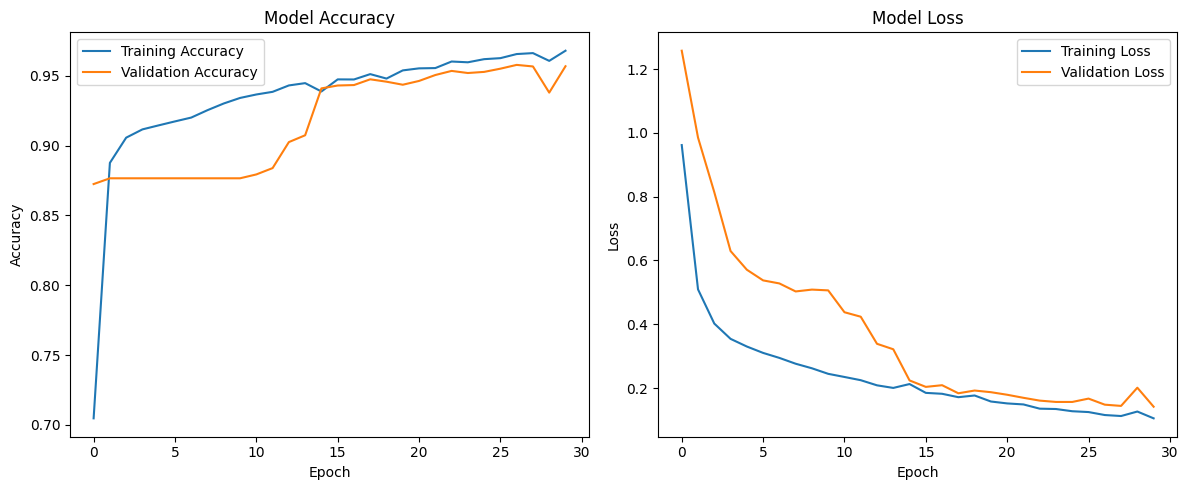

In [ ]:
pre_trained_Unet_model = load_saved_model('Custom_Unet_final.h5')
print('UNet model:')
plots(history_unet)

UNet model results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Mean IoU for background: 0.9736
Mean IoU for head: 0.6783
Mean IoU for flipper: 0.4924
Mean IoU for carapace: 0.5309


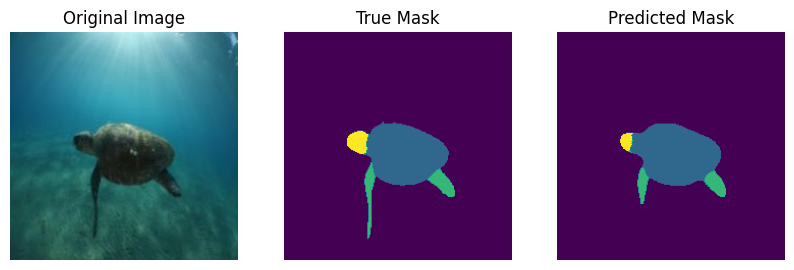

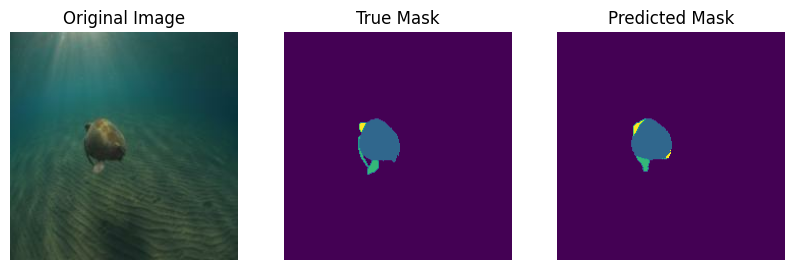

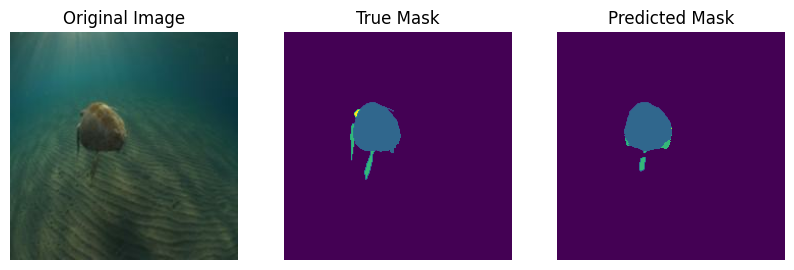

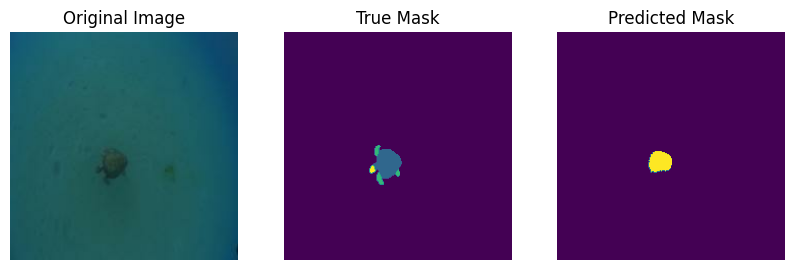

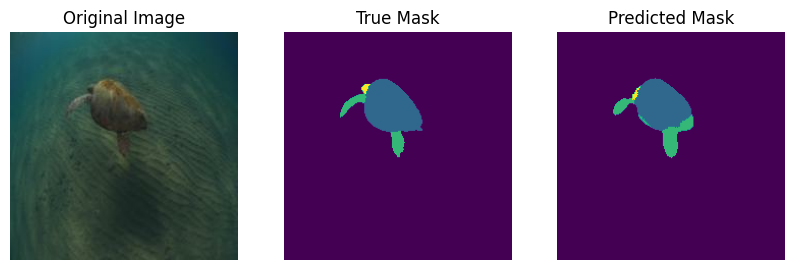

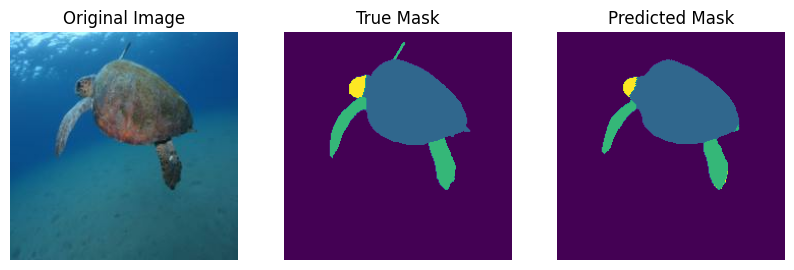

In [ ]:
print('UNet model results:')
unet_test = test_model(pre_trained_Unet_model, test_dataset)
unet_test

DeepLabV3 model

DeepLabV3 model:


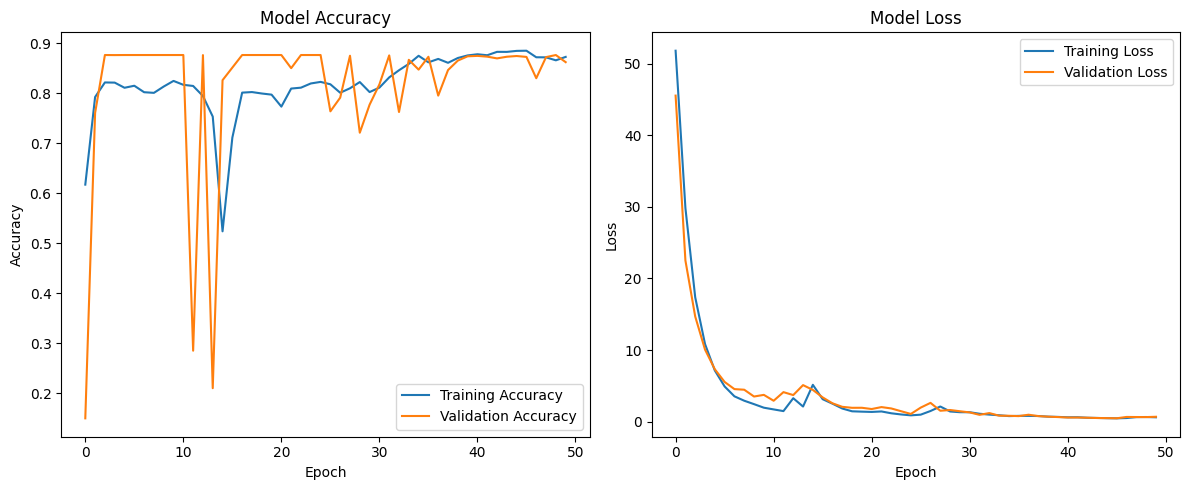

In [ ]:
pre_trained_deepLabV3_model = load_saved_model('deepLabV3_model.h5')
print('DeepLabV3 model:')
plots(history_deeplabV3)

DeepLabV3 model results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean IoU for background: 0.9796
Mean IoU for head: 0.7532
Mean IoU for flipper: 0.5069
Mean IoU for carapace: 0.5122


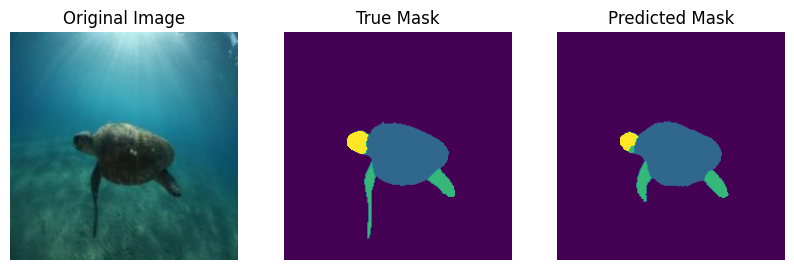

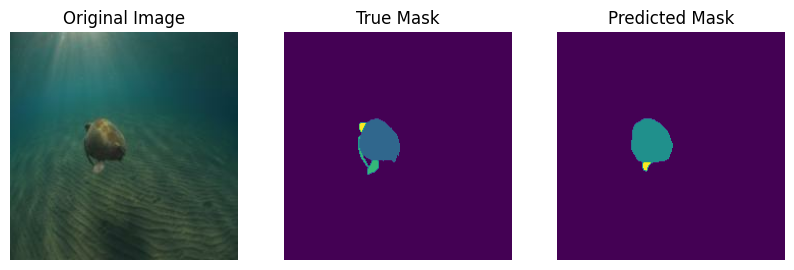

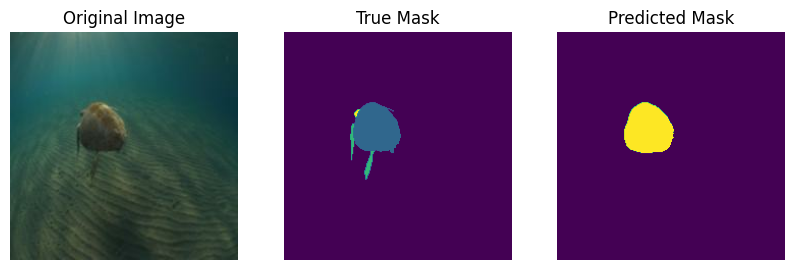

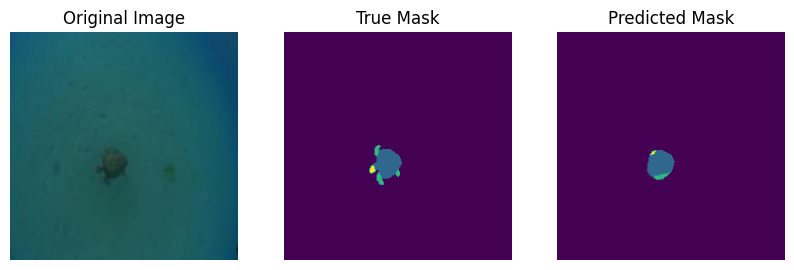

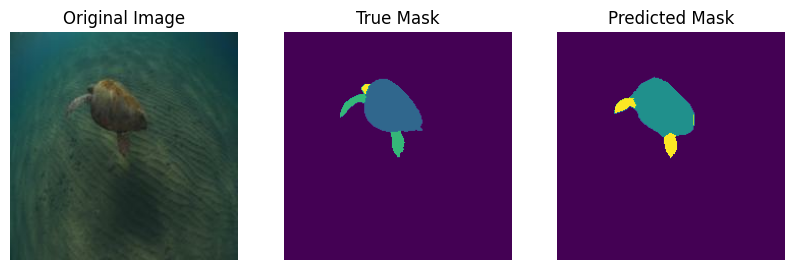

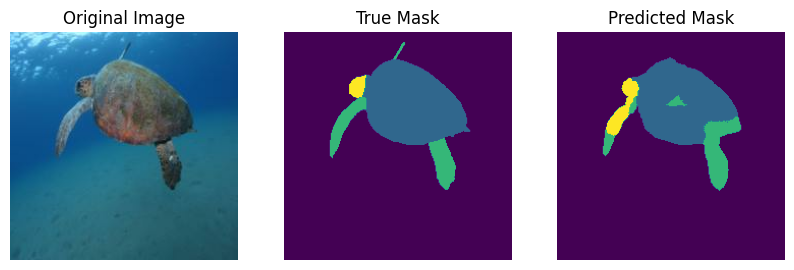

In [ ]:
print('DeepLabV3 model results:')
deeplabV3_test = test_model(pre_trained_deepLabV3_model, test_dataset)
deeplabV3_test

PSPNet model

PSPNet model:


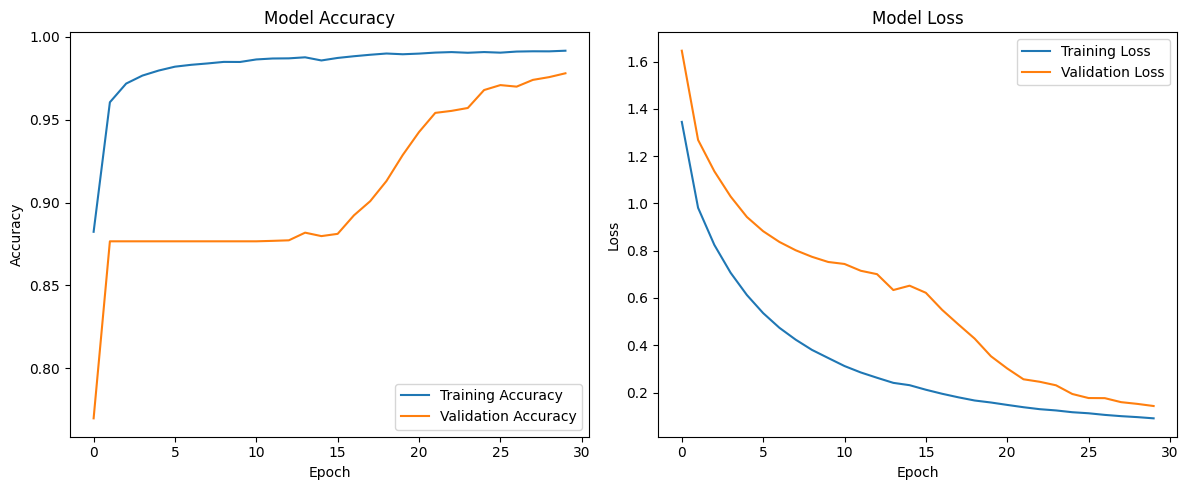

In [ ]:
pre_trained_psp_model = load_saved_model('psp_model.h5')
print('PSPNet model:')
plots(history_pspnet)

PSPNet model results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Mean IoU for background: 0.9880
Mean IoU for head: 0.8560
Mean IoU for flipper: 0.6938
Mean IoU for carapace: 0.7163


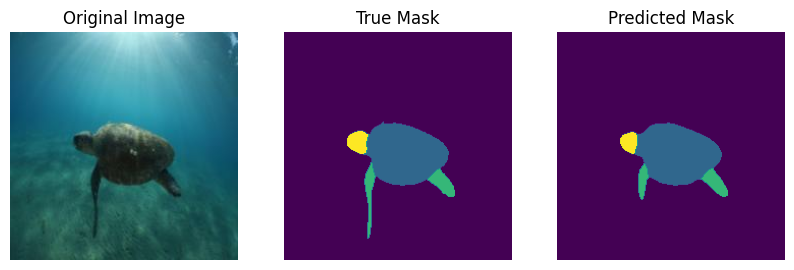

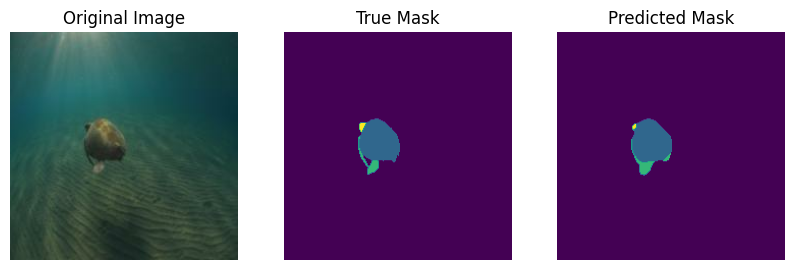

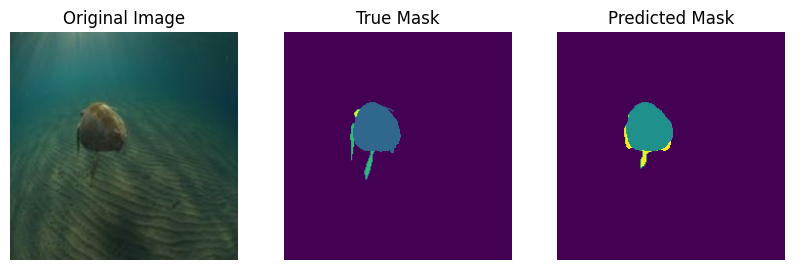

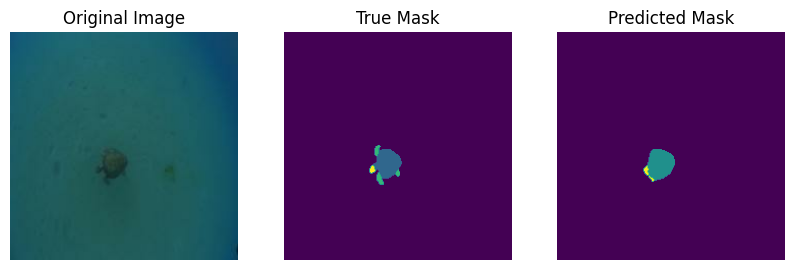

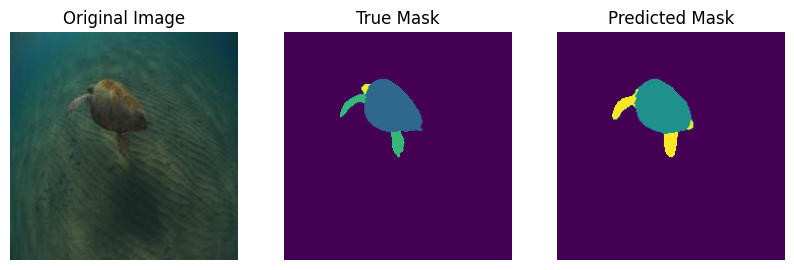

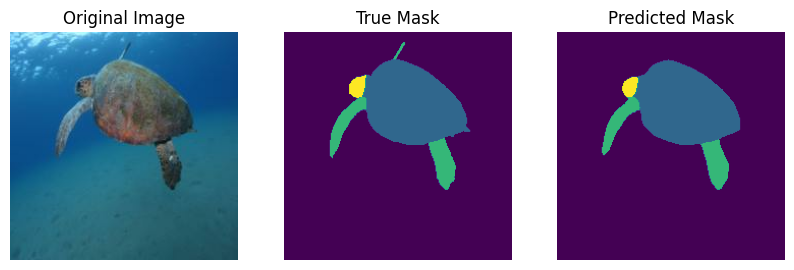

In [ ]:
print('PSPNet model results:')
psp_test = test_model(pre_trained_psp_model, test_dataset)
psp_test